In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import Holt
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler

In [19]:
df = pd.read_csv("data/btc-usd-max.csv")
df.head(5)
df.info()
#data.loc[data['total_volume'] > 0.0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   snapped_at    4324 non-null   object 
 1   price         4324 non-null   float64
 2   market_cap    4323 non-null   float64
 3   total_volume  4324 non-null   float64
dtypes: float64(3), object(1)
memory usage: 135.3+ KB


In [20]:
date_range = (df['snapped_at'].min(), df['snapped_at'].max())
date_range

('2013-04-28 00:00:00 UTC', '2025-03-01 00:00:00 UTC')

In [21]:
df['snapped_at'] = pd.to_datetime(df['snapped_at']).dt.strftime('%Y-%m-%d')
df.set_index('snapped_at', inplace = True)
df.sort_index(inplace = True)
df

,price,market_cap,total_volume
snapped_at,,,
2013-04-28,135.300000,1.500518e+09,0.000000e+00
2013-04-29,141.960000,1.575032e+09,0.000000e+00
2013-04-30,135.300000,1.501657e+09,0.000000e+00
2013-05-01,117.000000,1.298952e+09,0.000000e+00
2013-05-02,103.430000,1.148668e+09,0.000000e+00
...,...,...,...
2025-02-25,91396.766869,1.814177e+12,4.553970e+10
2025-02-26,88755.769336,1.759750e+12,9.674245e+10
2025-02-27,83900.114965,1.664315e+12,6.927743e+10


In [22]:
# Predicting only on data from 2023 onwards due to volatility
df.index = pd.to_datetime(df.index)
filtered = df[df.index >= pd.to_datetime("2023-01-01")]

/Users/audri/miniconda3/envs/htb/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/audri/miniconda3/envs/htb/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


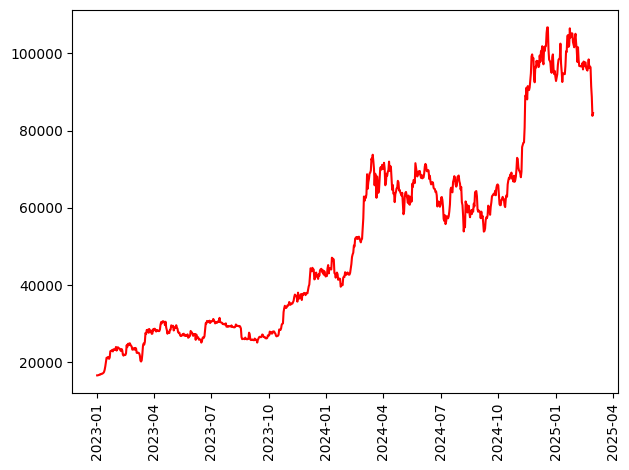

In [23]:
fit = Holt(filtered['price'], exponential=True).fit()  #exponential trend
plt.plot(fit.fittedvalues, color='r', markersize=4, markeredgewidth=1, label='Exponential Trend Fit')
plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()

In [24]:
# We will use 'price' as the target for prediction, and the other features as input
timeseries = filtered[['price', 'market_cap', 'total_volume']].values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
timeseries_scaled = scaler.fit_transform(timeseries)
print(timeseries_scaled)

# train-test split for time series
train_size = int(len(timeseries_scaled) * 0.7)
test_size = len(timeseries_scaled) - train_size
train, test = timeseries_scaled[:train_size], timeseries_scaled[train_size:]


[[0.0000000e+00 0.0000000e+00 3.8087234e-02]
 [8.3974004e-04 8.7171793e-04 3.0823128e-02]
 [1.4909208e-03 1.7999411e-03 4.1403051e-02]
 ...
 [7.5143093e-01 7.5520265e-01 2.2597072e-01]
 [7.6045609e-01 7.6375341e-01 1.0000001e+00]
 [7.5747478e-01 7.6105976e-01 2.6343247e-01]]


In [25]:
# LSTM adapted from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset"""
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback, :] 
        target = dataset[i+lookback, 0] 
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [26]:
# lstm model
class Model(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])  # keep only last output
        return x

In [27]:
def train_and_evaluate(hidden_size, lr, lookback, num_layers, batch_size, train, test):
    
    X_train, y_train = create_dataset(train, lookback)
    X_test, y_test = create_dataset(test, lookback)

    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=batch_size)

    model = Model(hidden_size=hidden_size, num_layers=num_layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    n_epochs = 1000
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_train_pred, y_train).item())
        y_test_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_test, y_test_pred))

    return model, test_rmse, train_rmse

In [ ]:
# Performs random hyperparam search
param_space = {
    'hidden_size': [20, 50, 100, 150],
    'lr': [0.0001, 0.0005, 0.001], 
    'lookback': [5, 10, 15, 20],   
    'num_layers': [1, 2],         
    'batch_size': [8, 16, 32]     
}

best_rmse = float('inf')
best_params = {}

for i in range(10):
    hidden_size = random.choice(param_space['hidden_size'])
    lr = random.choice(param_space['lr'])
    lookback = random.choice(param_space['lookback'])
    num_layers = random.choice(param_space['num_layers'])
    batch_size = random.choice(param_space['batch_size'])
    
    print(f"Trying hidden_size={hidden_size}, lr={lr}, lookback={lookback}, num_layers={num_layers}, batch_size={batch_size}")
    
    test_rmse, _ = train_and_evaluate(hidden_size, lr, lookback, num_layers, batch_size, train, test)
    
    print(f"Test RMSE: {test_rmse}")
    
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_params = {
            'hidden_size': hidden_size,
            'lr': lr,
            'lookback': lookback,
            'num_layers': num_layers,
            'batch_size': batch_size
        }

print(f"Best Hyperparameters: {best_params}")
print(f"Best Test RMSE: {best_rmse}")

"""
Best Hyperparameters: {'hidden_size': 100, 'lr': 0.001, 'lookback': 5, 'num_layers': 2, 'batch_size': 8}
Best Test RMSE: 0.381110817193985
"""

In [28]:
# Now we run based on best hyperparams
model, test_rmse, train_rmse = train_and_evaluate(100, 0.001, 5, 2, 8, train, test)
print(f"Train RMSE: {train_rmse}\n Test RMSE: {test_rmse}")

Train RMSE: 0.2588283293101768
 Test RMSE: 0.23798871040344238


/Users/audri/miniconda3/envs/htb/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([548])) that is different to the input size (torch.Size([548, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/audri/miniconda3/envs/htb/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([233, 1])) that is different to the input size (torch.Size([233])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/var/folders/zv/7g7rc4t52kx4pgdxw2c9g6740000gn/T/ipykernel_49911/3924747065.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_test, y_tes

In [29]:
def predict_future(model, scaler, train_data, lookback, num_steps):
    """
    Predict prices for the next num_steps number of days
    """
    # Scale data again?
    train_scaled = scaler.transform(train_data)
    last_train_input = torch.tensor([train_scaled[-lookback:]], dtype=torch.float32)
    
    model.eval()
    predictions = []

    # Predict for next num_steps number of days
    for _ in range(num_steps):
        with torch.no_grad():
            y_pred = model(last_train_input)
            predictions.append(y_pred.item())
            
            #Remove first timestep and pass onto the next day
            new_input = last_train_input[0, 1:, :].unsqueeze(0)
            new_input = torch.cat((new_input, torch.tensor([[[y_pred.item(), 0.0, 0.0]]], dtype=torch.float32)), dim=1)
            last_train_input = new_input
    
    # These will be in scaled form and need to be inversed to be interpretable
    return predictions

In [30]:
# Making predictions for next 5 days
num_steps = 5
future_predictions = predict_future(model, scaler, train, lookback=10, num_steps=num_steps)

In [31]:
# Returning predictions to interpretable values
predictions_scaled = np.array(future_predictions).reshape(-1, 1)
predictions_original = scaler.inverse_transform(np.hstack([predictions_scaled, np.zeros((predictions_scaled.shape[0], 2))]))[:,0]
print(f"Future predictions for the next {num_steps} days: {predictions_original}")

Future predictions for the next 5 days: [ 4874.82830008 19435.88716618 16062.33491404 15979.38403227
 25758.68522049]


In [33]:
filtered['price'].tail(5)

snapped_at
2025-02-25    91396.766869
2025-02-26    88755.769336
2025-02-27    83900.114965
2025-02-28    84709.144778
2025-03-01    84441.901224
Name: price, dtype: float64